In [20]:
import os
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cu116.html
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import GraphNorm
from torch_geometric.datasets import Planetoid
from torch_geometric.loader import NeighborSampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.0+cu116.html


# Load dataset

In [22]:
cora = Planetoid(root="./", name="Cora", split="public")
cora_dataset = cora[0]
cora_dataset

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [23]:
# Print size of train, validation, and test set
print(cora_dataset.train_mask.sum())
print(cora_dataset.val_mask.sum())
print(cora_dataset.test_mask.sum())

tensor(140)
tensor(500)
tensor(1000)


# Define Hyperparameters

In [24]:
args = {
    "learning_rate": 0.001,
    "num_epochs": 100,
    "hidden_size": 40,
    "neighbor_sample": 20,
    "experiment description": "Two-hop GraphSAGE Network, useing neighbor sampler module in Pytorch Geometric to do neighbor sampling as part of the GraphSAGE algorithm. Adam optimizer, learning rate 1e-3."
}

In [25]:
# Need to get node indices that are part of training set
train_node_idxs = torch.where(cora_dataset.train_mask == True)[0]
train_loader = NeighborSampler(cora_dataset.edge_index, sizes=[args["neighbor_sample"], args["neighbor_sample"]], node_idx=train_node_idxs, batch_size=1024, shuffle=True)

# Subgraph loader will be for evaluation
subgraph_loader = NeighborSampler(cora_dataset.edge_index, node_idx=None, sizes=[-1], batch_size=4096, shuffle=False)

# Define Network and Optimizer

In [26]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_features, hidden_size, num_classes):
        super().__init__()

        self.num_layers = 2

        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(input_features, hidden_size, normalize=False, root_weight=True, bias=True))
        self.convs.append(SAGEConv(hidden_size, hidden_size, normalize=False, root_weight=True, bias=True))

        self.norm1 = GraphNorm(hidden_size)
        self.norm2 = GraphNorm(hidden_size)

        self.lin1 = nn.Linear(in_features=hidden_size, out_features=num_classes)

    def forward(self, x, adjs):
        # Forward function code based on tutorial from PyTorch Geometric for handling neighbor sampling dataloader
        for i, (edge_index, _, size) in enumerate(adjs):
            x_target = x[:size[1]]  # Target nodes are always placed first.
            x = self.convs[i]((x, x_target), edge_index)

            # x = self.norm1(x) if i == 0 else self.norm2(x)
            x = F.relu(x)
            # x = F.dropout(x, p=0.5, training=True)  # Validation/Test will not call forward function

        x = self.lin1(x)
        return F.log_softmax(x, dim=1)
    
    def inference(self, x_all):

        total_edges = 0
        for i in range(self.num_layers):
            xs = []
            for batch_size, n_id, adj in subgraph_loader:
                edge_index, _, size = adj.to(device)
                total_edges += edge_index.size(1)
                x = x_all[n_id].to(device)
                x_target = x[:size[1]]
                x = self.convs[i]((x, x_target), edge_index)
                # x = self.norm1(x) if i == 0 else self.norm2(x)
                x = F.relu(x)
                xs.append(x.cuda())

            x_all = torch.cat(xs, dim=0)
        
        x = self.lin1(x_all)
        return F.log_softmax(x, dim=1)


In [27]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GraphSAGE(cora_dataset.num_node_features, hidden_size=args["hidden_size"], num_classes=cora.num_classes).to(device)
cora_dataset = cora_dataset.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=args["learning_rate"], weight_decay=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=args["learning_rate"], momentum=0.9)

In [28]:
print(model)
print(device)

GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1433, 40, aggr=mean)
    (1): SAGEConv(40, 40, aggr=mean)
  )
  (norm1): GraphNorm(40)
  (norm2): GraphNorm(40)
  (lin1): Linear(in_features=40, out_features=7, bias=True)
)
cuda


# Visualization

In [29]:
def plot_loss_curves(train_losses, val_losses):
    assert len(train_losses) == len(val_losses), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Loss": train_losses,
        "Validation Loss": val_losses,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Loss Value', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Loss Value", var_name="Dataset Split"))
    plt.title("Loss Curves")
    plt.show()

In [30]:
def plot_accuracy_curves(train_acc, val_acc):
    assert len(train_acc) == len(val_acc), "Inconsistent plotting sizes."
    
    time = list(range(args["num_epochs"]))
    visual_df = pd.DataFrame({
        "Train Accuracy": train_acc,
        "Validation Accuracy": val_acc,
        "Epoch": time
    })

    sns.lineplot(x='Epoch', y='Accuracy', hue='Dataset Split', data=pd.melt(visual_df, ['Epoch'], value_name="Accuracy", var_name="Dataset Split"))
    plt.title("Accuracy Curves")
    plt.show()

# Define Training and Evaluation Code

In [31]:
def train(model, cora_dataset):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    pbar = tqdm(total=args["num_epochs"])
    pbar.set_description(f'Epoch')

    for epoch in range(args["num_epochs"]):        
        model.train()
        optimizer.zero_grad()

        total_loss = 0.
        total_correct = 0.
        
        for batch_size, n_id, adjs in train_loader:
            adjs = [adj.to(device) for adj in adjs]

            out = model(cora_dataset.x[n_id], adjs)  # Pass sampled neighbors to model
            loss = F.nll_loss(out, cora_dataset.y[n_id[:batch_size]])
            total_loss += loss.item()
            loss.backward()
            optimizer.step()

            pred = out.argmax(dim=1)
            total_correct += (pred == cora_dataset.y[n_id[:batch_size]]).sum()
        
        train_acc = int(total_correct) / int(cora_dataset.train_mask.sum())
        train_losses.append(total_loss)
        train_accuracies.append(train_acc)

        # Validate once per epoch
        val_loss, val_acc = validation(model, cora_dataset)
        val_losses.append(val_loss.item())
        val_accuracies.append(val_acc)

        pbar.update(epoch)
    
    pbar.close()
    
    # Assert that sizes are all the same
    assert len(train_losses) == len(val_losses) == len(train_accuracies) == len(val_accuracies), "Metric list sizes are inconsistent."
    plot_loss_curves(train_losses, val_losses)
    plot_accuracy_curves(train_accuracies, val_accuracies)


In [32]:
def validation(model, cora_dataset):
    model.eval()
    out = model.inference(cora_dataset.x)
    pred = out.argmax(dim=1)
    
    val_loss = F.nll_loss(out[cora_dataset.val_mask], cora_dataset.y[cora_dataset.val_mask])
    correct = (pred[cora_dataset.val_mask] == cora_dataset.y[cora_dataset.val_mask]).sum()
    val_acc = int(correct) / int(cora_dataset.val_mask.sum())
    
    return val_loss, val_acc


In [33]:
def test(model, cora_dataset):
    model.eval()
    pred = model.inference(cora_dataset.x).argmax(dim=1)
    correct = (pred[cora_dataset.test_mask] == cora_dataset.y[cora_dataset.test_mask]).sum()
    accuracy = int(correct) / int(cora_dataset.test_mask.sum())
    print(f'Test Set Accuracy: {accuracy:.4f}')
    return accuracy

# Driver Code

Epoch: : 4950it [00:01, 3702.52it/s]


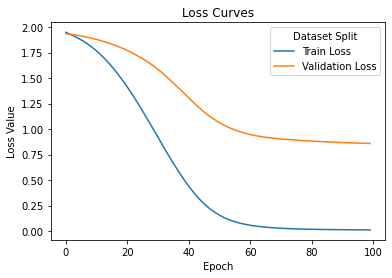

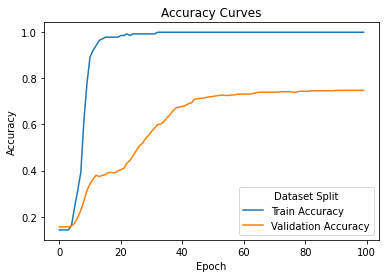

In [34]:
train(model, cora_dataset)

In [35]:
test_acc = test(model, cora_dataset)

# Save test accuracy so that we log it somewhere. Train and val accuracy are kept in the accuracy curves
args["test accuracy"] = test_acc

Test Set Accuracy: 0.7800


In [36]:
print(model)

GraphSAGE(
  (convs): ModuleList(
    (0): SAGEConv(1433, 40, aggr=mean)
    (1): SAGEConv(40, 40, aggr=mean)
  )
  (norm1): GraphNorm(40)
  (norm2): GraphNorm(40)
  (lin1): Linear(in_features=40, out_features=7, bias=True)
)


In [37]:

from sklearn.manifold import TSNE
def visualize(out, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.title("GraphSAGE")
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()
    plt.savefig('./GraphSAGE.png',dpi=600)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


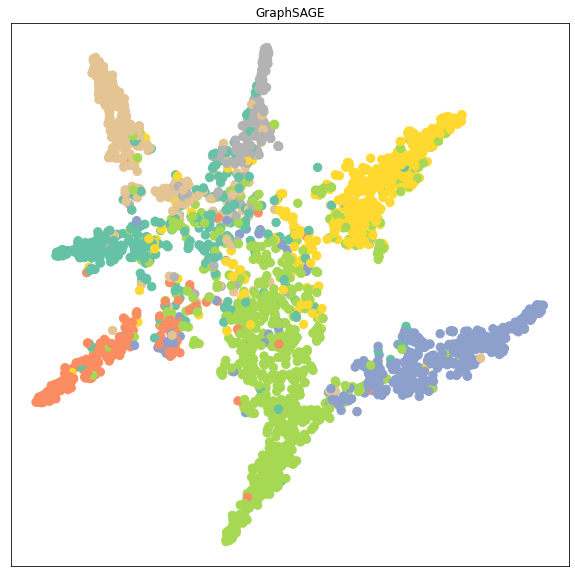

<Figure size 432x288 with 0 Axes>

In [38]:
out = model.inference(cora_dataset.x)
visualize(out, color=cora_dataset.y.detach().cpu().numpy())